In [1]:
%cd '/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2
import os
import sys
import numpy as np
import random
import pydot 
import sklearn.metrics

sys.path.append(os.getcwd())

from categorization.cnn import make_model, load_data, load_data_eyes, save_history

In [3]:
def load_all_models(save_path, features):
	all_models = list()
	for feature in features:
		# filename = save_path + str(feature) + '/save.h5'
		filename = save_path + str(feature) + '.h5'
		model = tf.keras.models.load_model(filename)
		all_models.append(model)
		print('loaded model of ' + str(feature))
	return all_models

def define_stacked_model(neural_nets, features):
    for model in neural_nets:
        for layer in model.layers:
            layer.trainable = False

    ensemble_visible = [model.input for model in neural_nets]
    ensemble_outputs = [model.layers[18].output for model in neural_nets]

    merge = tf.keras.layers.concatenate(ensemble_outputs)
    hidden = tf.keras.layers.Dense(32, activation='relu')(merge)
    hidden2 = tf.keras.layers.Dense(16, activation='relu')(hidden)
    hidden3 = tf.keras.layers.Dense(4, activation='relu')(hidden2)
    output = tf.keras.layers.Dense(2, activation='softmax')(hidden3)
    model = tf.keras.Model(inputs=ensemble_visible, outputs=output)

    # plot_model(model, show_shapes=True, to_file='data/plots/model_graph.png')
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TruePositives(), 
                  tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives()])
    return model


# def make_training_sets(face_features, image_folder_sick, image_folder_healthy, image_size):
#     train_sets_images = []
#     train_sets_labels = []
#     for feature in face_features:
#         print("[INFO] loading %s" %(feature))
#         if feature == "eyes":
#             train_images, train_labels = load_data_eyes(image_folder_sick, image_folder_healthy, image_size)
#             size = int(len(train_images)/2)
#             train_images = train_images[:size]
#             train_sets_labels.append(train_labels[:size])
#         else:
#             train_images, train_labels = load_data(image_folder_sick, image_folder_healthy, image_size, feature)
#         train_sets_images.append(train_images)
    
#     return train_sets_images, train_sets_labels

def make_training_sets(face_features, image_folder_sick, image_folder_healthy, image_folder_val_sick, image_folder_val_healthy,image_size):

    train_images_mouth, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "mouth")
    train_images_face, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "face")
    train_images_skin, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "skin")
    train_images_right_eye, train_labels = load_data(
        image_folder_sick, image_folder_healthy, image_size, "right")

    test_images_mouth, test_labels = load_data(image_folder_val_sick, image_folder_val_healthy, image_size, "mouth")
    test_images_face, test_labels = load_data(image_folder_val_sick, image_folder_val_healthy, image_size, "face")
    test_images_skin, test_labels = load_data(image_folder_val_sick, image_folder_val_healthy, image_size, "skin")
    test_images_right_eye, test_labels = load_data(image_folder_val_sick, image_folder_val_healthy, image_size, "right")

    perm1 = np.random.permutation(len(test_images_mouth))
    test_images = [test_images_mouth[perm1], test_images_face[perm1], test_images_skin[perm1], test_images_right_eye[perm1]]
    test_labels = test_labels[perm1]

    perm2 = np.random.permutation(len(train_labels))
    train_images = [train_images_mouth[perm2], train_images_face[perm2],
                    train_images_skin[perm2], train_images_right_eye[perm2]]

    train_labels = train_labels[perm2]

    return train_images, train_labels, test_images, test_labels


In [4]:
if __name__ == "__main__":

    save_path = 'categorization/model_saves/'
    image_folder_sick = 'data/parsed/sick-brightened'
    image_folder_healthy = 'data/parsed/healthy-brightened'
    image_folder_val_sick = 'data/parsed/validation-sick'
    image_folder_val_healthy = 'data/parsed/validation-healthy'
    face_features = ["mouth", "face", "skin", "eyes"]
    save_path = 'categorization/model_saves/'
    image_size = 128

    all_models = load_all_models(save_path, face_features)

    train_images, train_labels, test_images, test_labels = make_training_sets(face_features, image_folder_sick, image_folder_healthy, image_folder_val_sick, image_folder_val_healthy, image_size)

#     stacked = define_stacked_model(all_models, face_features)
# history = stacked.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=20, verbose=1)


loaded model of mouth
loaded model of face
loaded model of skin
loaded model of eyes


52


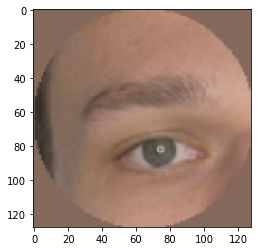

In [29]:
plt.imshow(train_images[3][1])
print(len(train_labels))

In [12]:
stacked = define_stacked_model(all_models, face_features)
history = stacked.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=20, verbose=1)


Train on 52 samples, validate on 30 samples
Epoch 1/20
52/52 [==============================] - 48s 924ms/sample - loss: 0.9621 - accuracy: 0.5192 - auc_2: 0.4608 - false_positives_2: 1.0000 - true_positives_2: 2.0000 - true_negatives_2: 25.0000 - false_negatives_2: 24.0000 - val_loss: 0.6852 - val_accuracy: 0.5000 - val_auc_2: 0.6933 - val_false_positives_2: 0.0000e+00 - val_true_positives_2: 0.0000e+00 - val_true_negatives_2: 15.0000 - val_false_negatives_2: 15.0000
Epoch 2/20
52/52 [==============================] - 23s 436ms/sample - loss: 0.7632 - accuracy: 0.5385 - auc_2: 0.5999 - false_positives_2: 1.0000 - true_positives_2: 3.0000 - true_negatives_2: 25.0000 - false_negatives_2: 23.0000 - val_loss: 0.6845 - val_accuracy: 0.5000 - val_auc_2: 0.6800 - val_false_positives_2: 1.0000 - val_true_positives_2: 1.0000 - val_true_negatives_2: 14.0000 - val_false_negatives_2: 14.0000
Epoch 3/20
52/52 [==============================] - 23s 435ms/sample - loss: 0.7797 - accuracy: 0.5769 - a

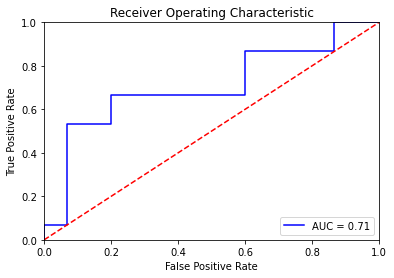

In [13]:
pred = stacked.predict(test_images)
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_labels, pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()